<a href="https://colab.research.google.com/github/OleKrarup123/NLSE-vector-solver/blob/main/SSFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About this notebook!!!
This notebook shows a simple, scalar implementation of the [Split-Step Fourier Method](https://en.wikipedia.org/wiki/Split-step_method) for solving the [Nonlinear Schrodinger Equation](https://https://en.wikipedia.org/wiki/Nonlinear_Schr%C3%B6dinger_equation),

$\frac{\partial A}{\partial z}=-\frac{\alpha}{2}A-i \frac{\beta_2}{2} \frac{\partial^2 A}{\partial T^2}+i\gamma|A|^2A$.

This nonlinear partial differential equation models how the envelope and phase of light pulse changes when propagating through an optical fiber, when taking power attenuation ($\alpha$), Group Velocity Dispersion ($\beta_2$) and waveguide nonlinearity ($\gamma$) causing Self-Phase Modulation (SPM) into account. 

If you are just starting your graduate studies in nonlinear optics, I encourage you to write your own implementation from scratch in a programming language of your choice as it's a great way to learn about the many exotic effects that can take place in optical fibers. 

This implementation contains a number of "TODO's" in the comments, which suggest features that a moderately experienced programmer should be able to implement without too much trouble. Consider downloading a copy of this notebook from my [GitHub page ](https://github.com/OleKrarup123/NLSE-vector-solver/blob/main/SSFM.ipynb), so you can play around with it on your own. 

If you want to learn more about experimental fiber optics, more than 20 tutorial videos are available on my [YouTube page](https://https://youtube.com/playlist?list=PLdFybGSAoPnnPkzL8zq6uR1yYZk4Ut_Zv). 


## Import useful libraries

In [1]:
import numpy as np
from scipy.fftpack import fft, ifft, fftshift, ifftshift, fftfreq

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

global pi; pi=np.pi 

## Define simulation parameters


In [2]:
N  = 2**15 #Number of points
dt = 0.1e-12 #Time resolution [s] 



## Define function for getting FFT frequency range from time vector

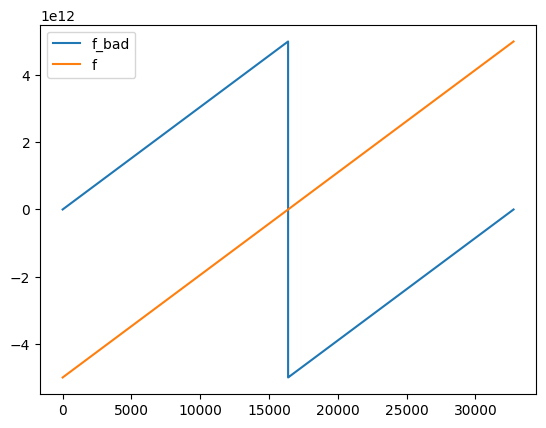

In [3]:
def getFreqRangeFromTime(time):
    return fftshift(fftfreq(len(time), d=time[1]-time[0]))


t=np.linspace(0,N*dt,N) #Time step array
t=t-np.mean(t)          #Center so middle entry is t=0

f_bad = fftfreq(len(t), d=t[1]-t[0]) 
f=getFreqRangeFromTime(t)



plt.figure()
plt.plot(f_bad,label="f_bad")
plt.plot(f,label="f")
plt.legend()
plt.show()

#NOTE: scipy is (for some reason) coded so the first entry is freq=0, the next 
#(N-1)/2 are all the positive frequencies and the remaining ones are the 
#negative ones. The function, fftshift, rearranges the entries so negative 
#frequencies come first

## Define functions for getting phase and chirp

In [4]:
def getPhase(pulse):
    phi=np.unwrap(np.angle(pulse)) #Get phase starting from 1st entry
    phi=phi-phi[int(len(phi)/2)]   #Center phase on middle entry
    return phi    


def getChirp(time,pulse):
    phi=getPhase(pulse)
    dphi=np.diff(phi ,prepend = phi[0] - (phi[1]  - phi[0]  ),axis=0) #Change in phase. Prepend to ensure consistent array size 
    dt  =np.diff(time,prepend = time[0]- (time[1] - time[0] ),axis=0) #Change in time.  Prepend to ensure consistent array size

    return -1.0/(2*pi)*dphi/dt #Chirp = - 1/(2pi) * d(phi)/dt

    
     

In [5]:
a=np.array([0-1j,1+0j,0+1j])
ph=getPhase(a)
print(ph)
print(type(ph[0]))
ch=getChirp(np.array([-1.0,0.0,1.0]),a)
print(ch)
print(type(ch[0]))

[-1.57079633  0.          1.57079633]
<class 'numpy.float64'>
[-0.25 -0.25 -0.25]
<class 'numpy.float64'>


## Define class to hold simulation parameters

In [6]:
#Class for holding info about the simulation params
class SIM_config:
    def __init__(self,N,dt):
        self.number_of_points=N # 计算的点数N
        self.time_step=dt # 时间步长dt
        t=np.linspace(0,N*dt,N) # 时间数组t
        self.t=t-np.mean(t) # 中心化，中间的点为t=0
        self.tmin=self.t[0] # 最小时间tmin
        self.tmax=self.t[-1] # 最大时间tmax
        
        self.f=getFreqRangeFromTime(self.t) # 频率数组f
        self.fmin=self.f[0] # 最小频率fmin
        self.fmax=self.f[-1] # 最大频率fmax
        self.freq_step=self.f[1]-self.f[0] # 频率步长freq_step

        self.describe_config()
        
    def describe_config(self):
        print("### Configuration Parameters ###")
        print(f" Number of points = {self.number_of_points}")
        print(f" Start time, tmin = {self.tmin*1e12}ps")
        print(f" Stop time, tmax = {self.tmax*1e12}ps")
        print(f" Time resolution, dt = {self.time_step*1e12}ps")
        print("  ")
        print(f" Start frequency= {self.fmin/1e12}THz")
        print(f" Stop frequency = {self.fmax/1e12}THz")
        print(f" Frequency resolution= {self.freq_step/1e6}MHz")
        print( "   ")

#Initialize class
sim_config=SIM_config(N,dt)

### Configuration Parameters ###
 Number of points = 32768
 Start time, tmin = -1638.4ps
 Stop time, tmax = 1638.4ps
 Time resolution, dt = 0.1ps
  
 Start frequency= -4.9998474121143825THz
 Stop frequency = 4.999542245646358THz
 Frequency resolution= 305.1664680244141MHz
   


## Functions for creating a Gaussian pulse to be simulated

In [7]:
#Function returns pulse power or spectrum PSD
def getPower(amplitude):
    return np.abs(amplitude)**2  

#Function gets the energy of a pulse pulse or spectrum by integrating the power
def getEnergy(time_or_frequency,amplitude):
    return np.trapz(getPower(amplitude),time_or_frequency)

#TODO: Add support for different carrier frequencies. Hint: Multiply by complex exponential!
#TODO: Add support for pre-chirped pulses. 
def GaussianPulse(time,amplitude,duration,offset,chirp,order):
  assert 1 <= order, f"Error: Order of gaussian pulse is {order}. Must be >=1"
  return amplitude*np.exp(- (1+1j*chirp)/2*((time-offset)/(duration))**(2*np.floor(order)))*(1+0j)



## Test functions:

In [8]:


#Initialize Gaussian pulse
amplitude = 1                       #Amplitude in units of sqrt(W)
duration  = 2**7*sim_config.time_step   #Pulse 1/e^2 duration [s]
offset    = 0                       #Time offset
testChirp = 0
testOrder = 1
testCarrierFreq=0
testPulse=GaussianPulse(t, amplitude, duration, offset,testChirp,testOrder)

super_order=10
testPulse_super=GaussianPulse(t, amplitude, duration, offset,testChirp,super_order)

testPulse_chrip=GaussianPulse(t, amplitude, duration, offset,1,1)



## Function for getting the spectrum corresponding to a given pulse

In [9]:
def getSpectrumFromPulse(time,pulse_amplitude):
    pulseEnergy=getEnergy(time,pulse_amplitude) #Get pulse energy
    f=getFreqRangeFromTime(time) 
    dt=time[1]-time[0]
    
    spectrum_amplitude=fftshift(fft(pulse_amplitude))*dt #Take FFT and do shift
    spectrumEnergy=getEnergy(f, spectrum_amplitude) #Get spectrum energy
    
    err=np.abs((pulseEnergy/spectrumEnergy-1))
    
    assert( err<1e-7 ), f'ERROR = {err}: Energy changed when going from Pulse to Spectrum!!!' 
    
    return spectrum_amplitude



#Equivalent function for getting time base from frequency range
def getTimeFromFrequency(frequency):  
    return fftshift(fftfreq(len(frequency), d=frequency[1]-frequency[0]))


#Equivalent function for getting pulse from spectrum
def getPulseFromSpectrum(frequency,spectrum_amplitude):
    
    spectrumEnergy=getEnergy(frequency, spectrum_amplitude)
    
    time = getTimeFromFrequency(frequency)
    dt = time[1]-time[0]
     
    pulse = ifft(ifftshift(spectrum_amplitude))/dt
    pulseEnergy = getEnergy(time, pulse)
    
    err=np.abs((pulseEnergy/spectrumEnergy-1))

    assert( err<1e-7   ), f'ERROR = {err}: Energy changed when going from Spectrum to Pulse!!!' 
    
    return pulse

#Equivalent function for generating a Gaussian spectrum
def GaussianSpectrum(frequency,amplitude,bandwidth):
    time = getTimeFromFrequency(frequency)
    return getSpectrumFromPulse(time, GaussianPulse(time, amplitude, 1/bandwidth, 0,0,1))

## Set up properties of the fiber

In [10]:
#Class for holding info about the fiber
class Fiber_config:
  def __init__(self,nsteps,L,gamma,beta2,alpha_dB_per_m):
      self.nsteps=nsteps # 光纤长度分割的步数
      self.ntraces = self.nsteps+1 #Note: If we want to do 100 steps, we will get 101 calculated pulses (zeroth at the input + 100 computed ones)
      self.Length=L # 光纤长度单位m
      self.dz=L/nsteps # 每一步的长度
      self.zlocs=np.linspace(0,L,self.ntraces) #Locations of each calculated pulse# 每一步的位置
      self.gamma=gamma # 非线性参数
      self.beta2=beta2 # 色散参数
      self.alpha_dB_per_m=alpha_dB_per_m # 衰减系数
      self.alpha_Np_per_m = self.alpha_dB_per_m*np.log(10)/10.0 #Loss coeff is usually specified in dB/km, but Nepers/km is more useful for calculations
      #TODO: Make alpha frequency dependent.  
  
#Define fiberulation parameters
Length          = 1e3      #Fiber length in m
nsteps          = 2**10     #Number of steps we divide the fiber into # 2**8=256 光纤长度分割的步数

gamma           = 10e-3     #Nonlinearity parameter in 1/W/m 
beta2           = 100e3    #Dispersion in fs^2/m (units typically used when referring to beta2) 
beta2          *= (1e-30)  #Convert fs^2 to s^2 so everything is in SI units
alpha_dB_per_m  = 0.2e-3   #Power attenuation coeff in decibel per m. Usual value at 1550nm is 0.2 dB/km

#Note:  beta2>0 is normal dispersion with red light pulling ahead, 
#       causing a negative leading chirp
#       
#       beta2<0 is anormalous dispersion with blue light pulling ahead, 
#       causing a positive leading chirp.

  
#  Initialize class
fiber=Fiber_config(nsteps, Length, gamma, beta2, alpha_dB_per_m)





## Define SSFM function

In [36]:
#TODO: Make returning the full matrices optional

def SSFM(fiber:Fiber_config,sim:SIM_config, pulse):
    
    #Initialize arrays to store pulse and spectrum throughout fiber
    pulseMatrix = np.zeros((fiber.nsteps+1,sim.number_of_points ) )*(1+0j)
    spectrumMatrix = np.copy(pulseMatrix)
    pulseMatrix[0,:]=pulse
    spectrumMatrix[0,:] = getSpectrumFromPulse(sim.t, pulse)

    #Pre-calculate effect of dispersion and loss as it's the same everywhere
    disp_and_loss=np.exp((1j*fiber.beta2/2*(2*pi*sim.f)**2-fiber.alpha_Np_per_m/2)*fiber.dz )
    
    #Precalculate constants for nonlinearity
    nonlinearity=1j*fiber.gamma*fiber.dz

    for n in range(fiber.nsteps):   
        pulse*=np.exp(nonlinearity*getPower(pulse)) #Apply nonlinearity
        spectrum = getSpectrumFromPulse(sim.t, pulse)*disp_and_loss #Go to spectral domain and apply disp and loss
        pulse=getPulseFromSpectrum(sim.f, spectrum) #Return to time domain 
        
        #Store results and repeat
        pulseMatrix[n+1,:]=pulse
        spectrumMatrix[n+1,:]=spectrum

    #Return results
    return pulseMatrix, spectrumMatrix

#Initial pulse and spectrum

#Run SSFM
pulseMatrix, spectrumMatrix = SSFM(fiber,sim_config,testPulse)



testPulse0=np.copy(pulseMatrix[0,:])
testSpectrum0=np.copy(spectrumMatrix[0,:])

testPulseFinal=np.copy(pulseMatrix[-1,:])
testSpectrumFinal=np.copy(spectrumMatrix[-1,:])



## Define functions for plotting pulses and spectra

In [37]:
#Function for optionally saving plots
def saveplot(basename,**kwargs):
  for kw, value in kwargs.items():
    if kw.lower()=='savename' and type(value)==str:
      savestring=basename+'_'+value
      if value.lower().endswith(('.pdf','.png','.jpg')) == False:
        savestring+='.png'
      plt.savefig(savestring,
                  dpi=500,
                  bbox_inches='tight', 
                  transparent=True,
                  pad_inches=0)




In [38]:
params = {
          # "text.color" : "purple",
          # "axes.labelcolor" : "purple",   # x and y labels 坐标轴标题颜色
          # "xtick.color" : "purple",        # x轴刻度和数值颜色
          # "ytick.color" : "purple",     # y轴刻度和数值颜色
          'axes.edgecolor': '(0,0,0,0)',     # 图边框颜色'purple'
          'legend.framealpha': 0,     # 图例透明度
          # 'legend.edgecolor': 'purple',  # 图例边框颜色
          'legend.facecolor': '(0,0,0,0)',  # 图例背景颜色
          }
plt.rcParams.update(params)

def plotFirstAndLastPulse(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int,**kwargs):
  t=sim.t[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]*1e12
  plt.figure()
  plt.title("Initial pulse and final pulse")
  plt.plot(t,getPower(matrix[0,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]),label="Initial Pulse")
  plt.plot(t,getPower(matrix[-1,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]),label="Final Pulse")
  #plt.axis([-duration*5*1e12,duration*5*1e12,0,1.05*amplitude**2])
  plt.xlabel("Time [ps]")
  plt.ylabel("Power [W]")
  plt.legend()
  saveplot('first_and_last_pulse',**kwargs)
  plt.show()  


def plotPulseMatrix2D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff,**kwargs):
  #Plot pulse evolution throughout fiber in normalized log scale
  fig, ax = plt.subplots()
  ax.set_title('Pulse Evolution (dB scale)')
  t = sim.t[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]*1e12
  z = fiber.zlocs 
  T, Z = np.meshgrid(t, z)
  P=getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  P[P<1e-100]=1e-100
  P = 10*np.log10(P)
  P[P<dB_cutoff]=dB_cutoff
  surf=ax.contourf(T, Z, P,levels=40, cmap="jet")
  ax.set_xlabel('Time [ps]')
  ax.set_ylabel('Distance [m]')
  cbar=fig.colorbar(surf, ax=ax)
  saveplot('pulse_evo_2D',**kwargs) 
  plt.show()

def plotPulseMatrix3D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff,**kwargs):
  #Plot pulse evolution in 3D
  fig, ax = plt.subplots(1,1, figsize=(10,7),subplot_kw={"projection": "3d"})
  plt.title("Pulse Evolution (dB scale)")

  t = sim.t[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]*1e12
  z = fiber.zlocs 
  T_surf, Z_surf = np.meshgrid(t, z)
  P_surf=getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  P_surf[P_surf<1e-100]=1e-100
  P_surf = 10*np.log10(P_surf)
  P_surf[P_surf<dB_cutoff]=dB_cutoff
  # Plot the surface.
  surf = ax.plot_surface(T_surf, Z_surf, P_surf, cmap=cm.viridis,
                        linewidth=0, antialiased=False)
  ax.set_xlabel('Time [ps]')
  ax.set_ylabel('Distance [m]')
  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)
  saveplot('pulse_evo_3D',**kwargs)
  plt.show()


def plotPulseChirp2D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int,**kwargs):
  #Plot pulse evolution throughout fiber in normalized log scale
  fig, ax = plt.subplots()
  ax.set_title('Pulse Chirp Evolution')
  t = sim.t[int(sim_config.number_of_points/2-nrange):int(sim_config.number_of_points/2+nrange)]*1e12
  z = fiber.zlocs 
  T, Z = np.meshgrid(t, z)
  
  Cmatrix=np.ones( (len(z),len(t))  )*1.0

  for i in range(fiber.ntraces):
    Cmatrix[i,:]=getChirp(t/1e12,matrix[i,int(sim_config.number_of_points/2-nrange):int(sim_config.number_of_points/2+nrange)])/1e9


  for kw, value in kwargs.items():
    if kw.lower()=='chirpplotrange' and type(value)==tuple:
      Cmatrix[Cmatrix<value[0]]=value[0]
      Cmatrix[Cmatrix>value[1]]=value[1]
  

  surf=ax.contourf(T, Z, Cmatrix,levels=40,cmap='RdBu')
  
  ax.set_xlabel('Time [ps]')
  ax.set_ylabel('Distance [m]')
  cbar=fig.colorbar(surf, ax=ax)
  cbar.set_label('Chirp [GHz]')
  saveplot('chirp_evo_2D',**kwargs) 
  plt.show()


def plotEverythingAboutPulses(pulseMatrix,fiber:Fiber_config,
                              sim:SIM_config, 
                              nrange:int, 
                              dB_cutoff,
                              **kwargs):
  
  print('  ')
  plotFirstAndLastPulse(pulseMatrix,fiber,sim, nrange,**kwargs)
  plotPulseMatrix2D(pulseMatrix,fiber,sim,nrange,dB_cutoff,**kwargs)
  plotPulseChirp2D(pulseMatrix,fiber,sim,nrange,**kwargs) 
  plotPulseMatrix3D(pulseMatrix,fiber,sim,nrange,dB_cutoff,**kwargs)
  
  print('  ')  


def plotFirstAndLastSpectrum(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int,**kwargs):
  f=sim.f[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]/1e9
  plt.figure()
  plt.title("Initial spectrum and final spectrum")
  plt.plot(f,getPower(matrix[0,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)])*1e9,label="Initial Spectrum")
  plt.plot(f,getPower(matrix[-1,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)])*1e9,label="Final Spectrum")
  plt.xlabel("Freq. [GHz]")
  plt.ylabel("PSD [W/GHz]")
  plt.legend()
  saveplot('first_and_last_spectrum',**kwargs)
  plt.show()

def plotSpectrumMatrix2D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff,**kwargs):
  #Plot pulse evolution throughout fiber in normalized log scale
  fig, ax = plt.subplots()
  ax.set_title('Spectrum Evolution (dB scale)')
  f = sim.f[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]/1e9 
  z = fiber.zlocs 
  F, Z = np.meshgrid(f, z)
  Pf=getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  Pf[Pf<1e-100]=1e-100
  Pf = 10*np.log10(Pf)
  Pf[Pf<dB_cutoff]=dB_cutoff
  surf=ax.contourf(F, Z, Pf,levels=40)
  ax.set_xlabel('Freq. [GHz]')
  ax.set_ylabel('Distance [m]')
  cbar=fig.colorbar(surf, ax=ax) 
  saveplot('spectrum_evo_2D',**kwargs) 
  plt.show()

def plotSpectrumMatrix3D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff,**kwargs):
  #Plot pulse evolution in 3D
  fig, ax = plt.subplots(1,1, figsize=(10,7),subplot_kw={"projection": "3d"})
  plt.title("Spectrum Evolution (dB scale)")

  f = sim.f[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]/1e9 
  z = fiber.zlocs 
  F_surf, Z_surf = np.meshgrid(f, z)
  P_surf=getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  P_surf[P_surf<1e-100]=1e-100
  P_surf = 10*np.log10(P_surf)
  P_surf[P_surf<dB_cutoff]=dB_cutoff
  # Plot the surface.
  surf = ax.plot_surface(F_surf, Z_surf, P_surf, cmap=cm.viridis,
                        linewidth=0, antialiased=False)
  ax.set_xlabel('Freq. [GHz]')
  ax.set_ylabel('Distance [m]')
  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)
  saveplot('spectrum_evo_3D',**kwargs) 
  plt.show()


def plotEverythingAboutSpectra(spectrumMatrix, # 光谱矩阵
                               fiber:Fiber_config, # 光纤属性
                               sim:SIM_config,  # 仿真参数
                               nrange:int, # 画图范围
                               dB_cutoff, # 画图范围
                               **kwargs):
  
  print('  ')  
  plotFirstAndLastSpectrum(spectrumMatrix,fiber,sim, nrange,**kwargs)
  plotSpectrumMatrix2D(spectrumMatrix,fiber,sim,nrange,dB_cutoff,**kwargs)
  plotSpectrumMatrix3D(spectrumMatrix,fiber,sim,nrange,dB_cutoff,**kwargs)

  print('  ')  


#Plot pulses
nrange=600 # 时域的范围 -60，60ps
cutoff=-30 # 时域强度截止值dB

# plotEverythingAboutPulses(pulseMatrix,fiber,sim_config,nrange,cutoff,savename='gaussian',chirpPlotRange=(-40,40))

#Plot spectra
nrange=400 # 频域的范围
cutoff=-30 # 频域强度截止值dB
# plotEverythingAboutSpectra(spectrumMatrix,fiber,sim_config,nrange,cutoff,savename='gaussian')


#TODO: Make plot of evolution of pulse chirp throughout the fiber

...\
...\
...\
...\
...\
...\
...

# Solitons

Pulses launched into an optical fiber will evolve according to the NLSE,

$\frac{\partial A}{\partial z}=-i \frac{\beta_2}{2} \frac{\partial^2 A}{\partial T^2}+i\gamma|A|^2A$.


When $\beta_2$ is negative (anormalous dispersion), the term representing Group Velocity Dispersion (GVD), $-i \frac{\beta_2}{2} \frac{\partial^2 A}{\partial T^2}$,  will cause a positive (blue) chirp in the front and and a negative (red) chirp in the back. Similarly, the term representing self-phase modulation (SPM), $i\gamma|A|^2A$, will cause a red chirp in the front and a blue chirp in the back. 

Since the chirp caused by GVD depends on the 2nd derivative (curvature) of the pulse, while the oppositely signed chirp of SPM depends on the squared amplitude of the pulse, we can ask the following question:

"Is there some pulse envelope, where the effects of GVD and SPM exactly cancel out, causing the pulse to retain its shape as it propagates?"

Such a pulse is called a "soliton". An analytical derivation of the most simplt type can be found through [this link](https://github.com/OleKrarup123/NLSE-vector-solver/blob/main/Fundamental%20soliton%20derivation.pdf).



## Investigate solitons numerically

In [39]:
#Define sech pulse
def sechPulse(time,amplitude,duration,offset,chirp):
  return amplitude/np.cosh((time-offset)/duration)*np.exp(- (1j*chirp)/2*((time-offset)/(duration))**2)*(1+0j)

## Define fiber and pulse parameters

In [40]:
offset_test=0
duration_test=2**7*sim_config.time_step


#Fiber params
nsteps_test          = 2**8     #Number of steps we divide the fiber into   改改

gamma_test           = 10e-3     #Nonlinearity parameter in 1/W/m 
beta2_test           = -100e3    #Dispersion in fs^2/m (units typically used when referring to beta2) 
beta2_test          *= (1e-30)  #Convert fs^2 to s^2 so everything is in SI units
alpha_dB_per_m_test  = 0.0e-3   #Power attenuation coeff in decibel per m. Usual value at 1550nm is 0.2 dB/km

z_char= pi/2*duration_test**2/np.abs(beta2_test) #Characteristic length
Length_test          = (9)* z_char       #Fiber length in m             改改


#  Initialize class
fiber_test=Fiber_config(nsteps_test, Length_test, gamma_test, beta2_test, alpha_dB_per_m_test)

#Note:  beta2>0 is normal dispersion with red light pulling ahead, 
#       causing a negative leading chirp
#       
#       beta2<0 is anormalous dispersion with blue light pulling ahead, 
#       causing a positive leading chirp.


####### CAREFULLY CHOSEN PULSE AMPLITUDE ######
N=1.2                         # 改改
A_char = np.sqrt(np.abs(beta2_test)/gamma_test/duration_test**2)
amplitude_test=A_char*N

#########################################


## Create sech pulse, Gaussian pulse and square pulse for comparison 

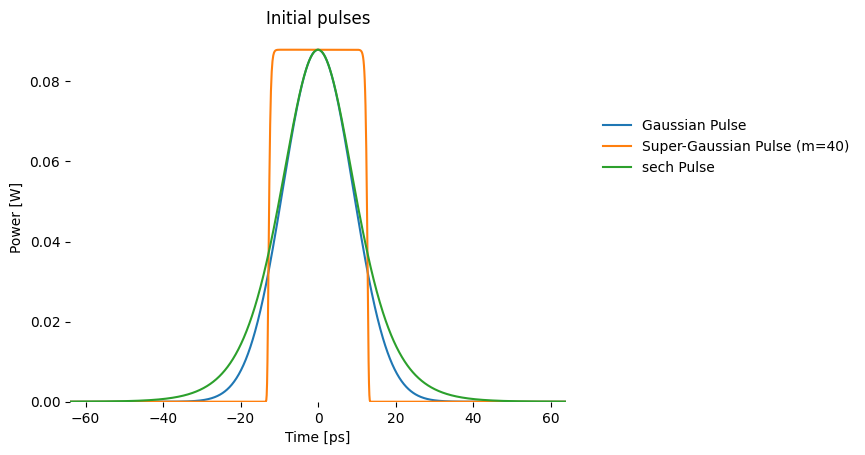

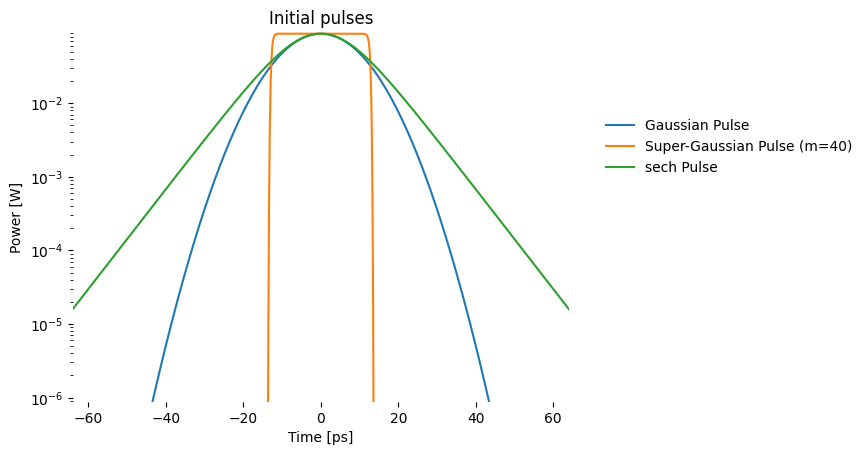

In [41]:

#Generate sech pulse
testPulse_sech=sechPulse(sim_config.t,amplitude_test,duration_test,0,0)

#Generate Gaussian pulse and square pulse for comparison
testPulse_gauss=GaussianPulse(sim_config.t, amplitude_test, duration_test, offset_test,0,1)

super_order=20
testPulse_super=GaussianPulse(sim_config.t,amplitude_test, duration_test, offset_test,0,super_order)


plt.figure()
plt.title("Initial pulses")
plt.plot(sim_config.t*1e12,getPower(testPulse_gauss),label='Gaussian Pulse')
plt.plot(sim_config.t*1e12,getPower(testPulse_super),label=f'Super-Gaussian Pulse (m={2*super_order})')
plt.plot(sim_config.t*1e12,getPower(testPulse_sech),label=f'sech Pulse ')
plt.axis([-duration_test*3*1e12,duration_test*3*1e12,0,1.05*amplitude**2])
plt.xlabel("Time [ps]")
plt.ylabel("Power [W]")
plt.legend(bbox_to_anchor=(1.05,0.8))
plt.axis([-duration_test*5*1e12,duration_test*5*1e12,0,1.05*amplitude_test**2])
plt.show()


plt.figure()
plt.title("Initial pulses")
plt.plot(sim_config.t*1e12,getPower(testPulse_gauss),label='Gaussian Pulse')
plt.plot(sim_config.t*1e12,getPower(testPulse_super),label=f'Super-Gaussian Pulse (m={2*super_order})')
plt.plot(sim_config.t*1e12,getPower(testPulse_sech),label=f'sech Pulse ')
plt.xlabel("Time [ps]")
plt.ylabel("Power [W]")
plt.legend(bbox_to_anchor=(1.05,0.8))
plt.axis([-duration_test*5*1e12,duration_test*5*1e12,1e-5*amplitude_test**2,1.05*amplitude_test**2])
plt.yscale('log')
plt.show()




## Propagate sech pulse through fiber

In [42]:
pulseMatrix_sech, spectrumMatrix_sech = SSFM(fiber_test,sim_config,testPulse_sech)

## Plot result

Sech pulse:
  


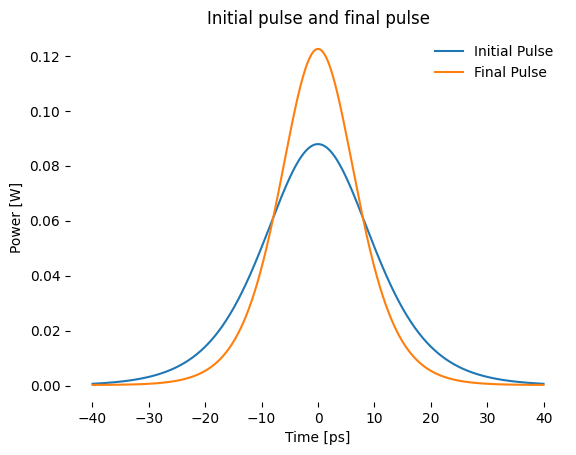

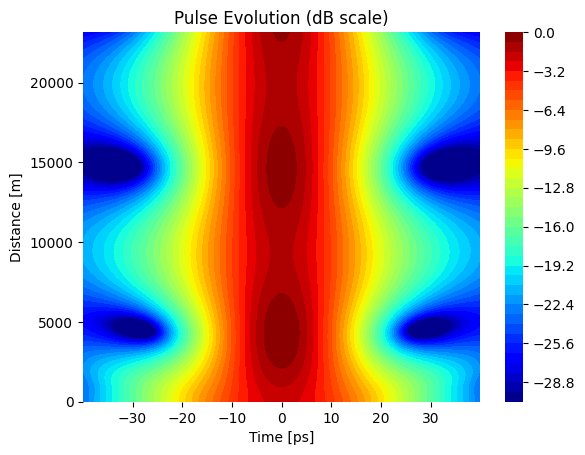

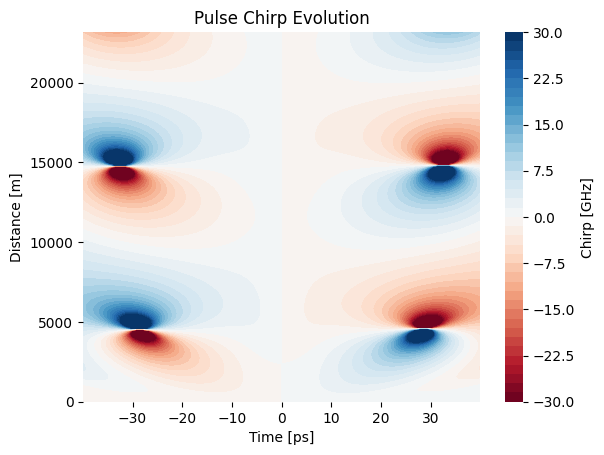

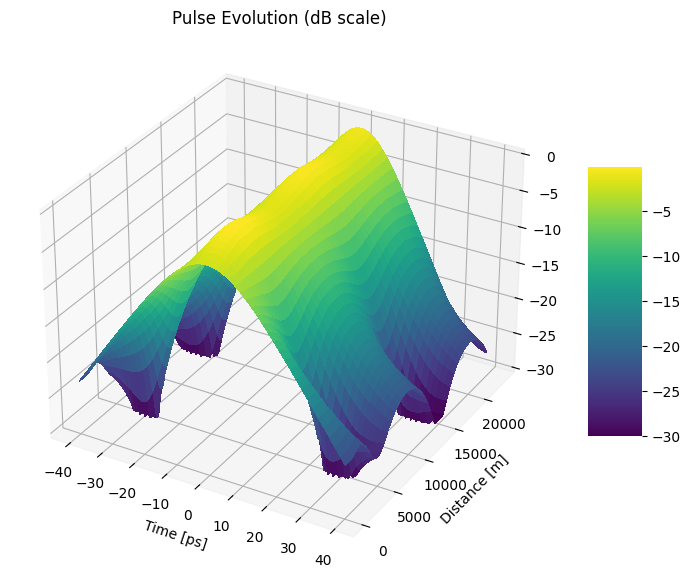

In [43]:
#Plot pulses
nrange=400
cutoff=-30

print("Sech pulse:")
plotEverythingAboutPulses(pulseMatrix_sech,fiber_test,sim_config,nrange,cutoff,chirpPlotRange=(-30,30), savename=f'Soliton-N={N}')




# Dark solitons

Regular solitons require anormalous dispersion. This means that $\beta_2$ is negative in the NLSE:

$\frac{\partial A}{\partial z}=-i \frac{\beta_2}{2} \frac{\partial^2 A}{\partial T^2}+i\gamma|A|^2A$.

In that case, SPM caused a negative chirp at the upwards slope in the front of the pulse, which was cancelled out by the positive chirp from anormalous GVD. 

But what if $\beta_2$ is positive?

In that case, upwards slopes will still produce a red chirp due to SPM, and become "even more" red due to normal dispersion. Similarly, downwards slopes will still become blue chirped due to SPM and even more blue chirped due to GVD:



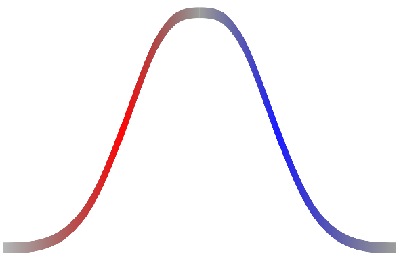

Clearly, this pulse will tend to spread out quickly since red light propagates faster than blue light when we have normal dispersion. 

But what if we "swap" the slopes of the pulse as shown below?

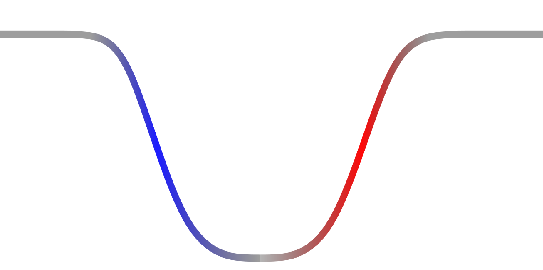

Now the blue light should transfer its power to the right, while the red light transfers its power to the left. If we can somehow define this "dip" to have the correct geometry, maybe we can ensure that every segment of the pulse receives as much power from the left as it does from the right. Instead of a "**Bright Soliton**", which consists of a power peak that retains its shape, we would have a "**Dark Soliton**"; a **dip** which retains its shape!

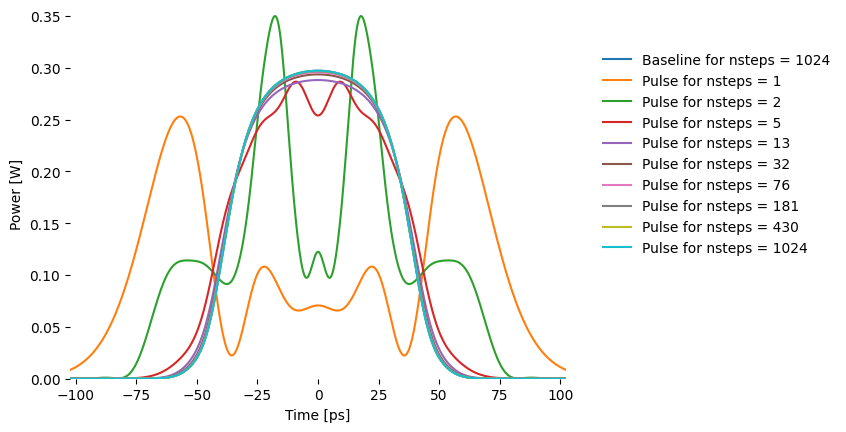

In [44]:

#First, make a copy of the pulse computed with the original fiber settings and nsteps
baselinePulse = np.copy(testPulseFinal)

#Make array of the number of steps
nsteps_list=np.logspace(0,np.log10(fiber.nsteps),9)  

#Pre-define arrays for holding errors
err_list=np.zeros_like(nsteps_list)*1.0


#Start figure and plot the pulse with the large number of steps
plt.figure()
plt.plot(sim_config.t*1e12,getPower(baselinePulse),label=f"Baseline for nsteps = {fiber.nsteps}")

#For each iteration, define a new fiber with a different number of steps but the same physical properties
for i in range(0,len(nsteps_list)):
  nsteps_i=int(nsteps_list[i])
  fiber_i=Fiber_config(nsteps_i, fiber.Length, fiber.gamma, fiber.beta2, fiber.alpha_dB_per_m)
  
  #Run the simulation and plot the computed pulse
  pulseMatrix_i,_=SSFM(fiber_i,sim_config,np.copy(testPulse0))
  
  pulse_i=pulseMatrix_i[-1,:]
  
  plt.plot(sim_config.t*1e12,getPower(pulse_i),label=f"Pulse for nsteps = {nsteps_i}")
  
  #Compute and store errors
  err = getEnergy(sim_config.t,(pulse_i-baselinePulse))/getEnergy(sim_config.t, baselinePulse)*100
  err_list[i]=err


plt.xlabel("Time [ps]")
plt.ylabel("Power [W]")
plt.axis([-duration*8*1e12,duration*8*1e12,0,1.2*np.max(getPower(baselinePulse))])
plt.legend(bbox_to_anchor=(1.05,0.3))
plt.show()







## Define dark pulse

In [45]:
 #Define sech pulse
def darkPulse(time,amplitude,dip,duration,offset,chirp):
  assert 0.0<=dip and dip <= 1.0, f"ERROR: The value of dip is {dip}, but it must be between 0 and 1!!!"
  t_char = dip*((time-offset)/duration-dip*np.sqrt(1-dip**2))
  
  return (1+0j)*amplitude*(dip*np.tanh(t_char)-i*np.sqrt(1-dip**2)   )*GaussianPulse(time,1,duration*40,offset,chirp,50)

## Initialize dark pulse and fiber

In [46]:
duration_dark = sim_config.time_step*2**7
dip_dark=1.0


#Define fiberulation parameters

nsteps_dark          = 2**11     #Number of steps we divide the fiber into

gamma_dark           = 10e-3     #Nonlinearity parameter in 1/W/m 
beta2_dark           = 100e3    #Dispersion in fs^2/m (units typically used when referring to beta2) 
beta2_dark          *= (1e-30)  #Convert fs^2 to s^2 so everything is in SI units
alpha_dB_per_m_dark  = 0.0e-3   #Power attenuation coeff in decibel per m. Usual value at 1550nm is 0.2 dB/km

#Note:  beta2>0 is normal dispersion with red light pulling ahead, 
#       causing a negative leading chirp
#       
#       beta2<0 is anormalous dispersion with blue light pulling ahead, 
#       causing a positive leading chirp.

z_char_dark= pi/2*duration_dark**2/np.abs(beta2_dark) #Characteristic length
Length_dark          = (2.5)* z_char_dark       #Fiber length in m

  
#  Initialize class
fiber_dark=Fiber_config(nsteps_dark, Length_dark, gamma_dark, beta2_dark, alpha_dB_per_m_dark)

####### CAREFULLY CHOSEN PULSE AMPLITUDE ######
N_dark=3.0
A_char_dark = np.sqrt(np.abs(beta2_dark)/gamma_dark/duration_dark**2)
amplitude_dark=A_char_dark*N_dark

#########################################


testPulse_dark = darkPulse(sim_config.t,amplitude_dark,dip_dark,duration_dark,0,0 )

## Plot dark pulse

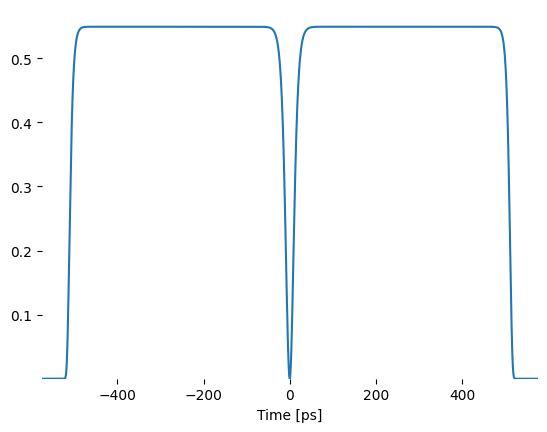

In [47]:

plt.figure()
plt.plot(sim_config.t*1e12,getPower(testPulse_dark))
plt.axis([-duration_dark*45*1e12,duration_dark*45*1e12,1e-5*amplitude_dark**2,1.05*amplitude_dark**2])
plt.xlabel('Time [ps]')
plt.show()

In [48]:
pulseMatrix_dark, spectrumMatrix_dark = SSFM(fiber_dark,sim_config,testPulse_dark)

dark pulse:
  


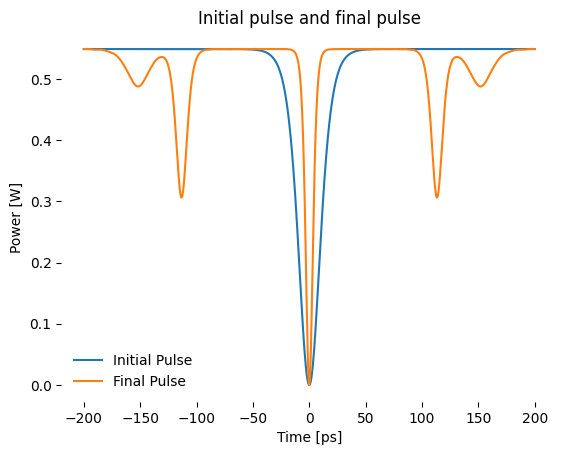

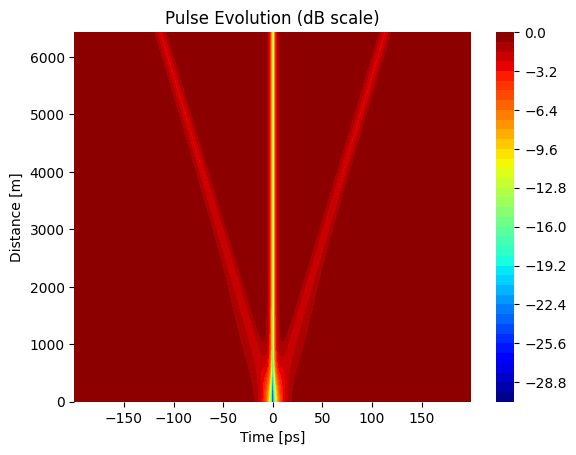

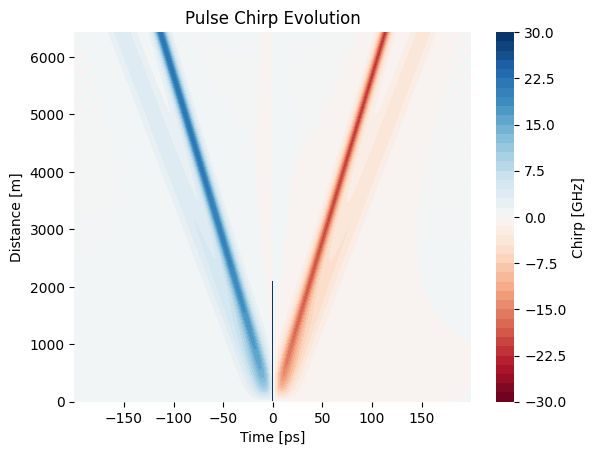

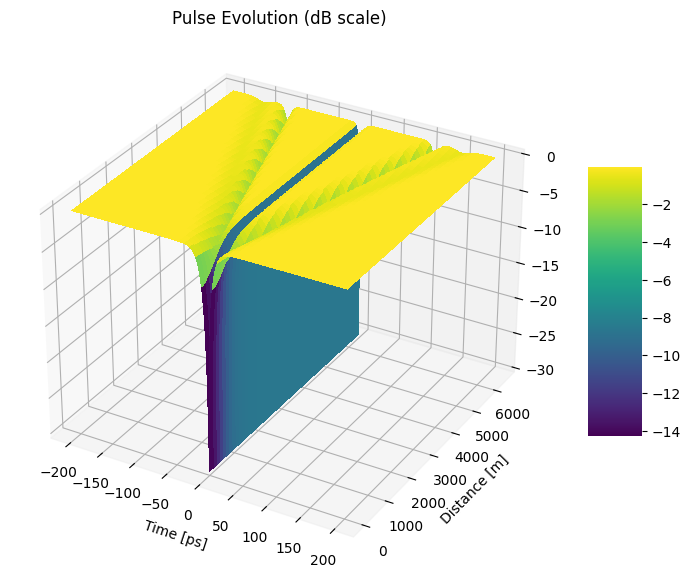

In [49]:
#Plot pulses
nrange=2000
cutoff=-30

print("dark pulse:")
plotEverythingAboutPulses(pulseMatrix_dark,fiber_dark,sim_config,nrange,cutoff,chirpPlotRange=(-30,30),savename="darkSoliton.png")


## Make .gif animation of soliton evolution

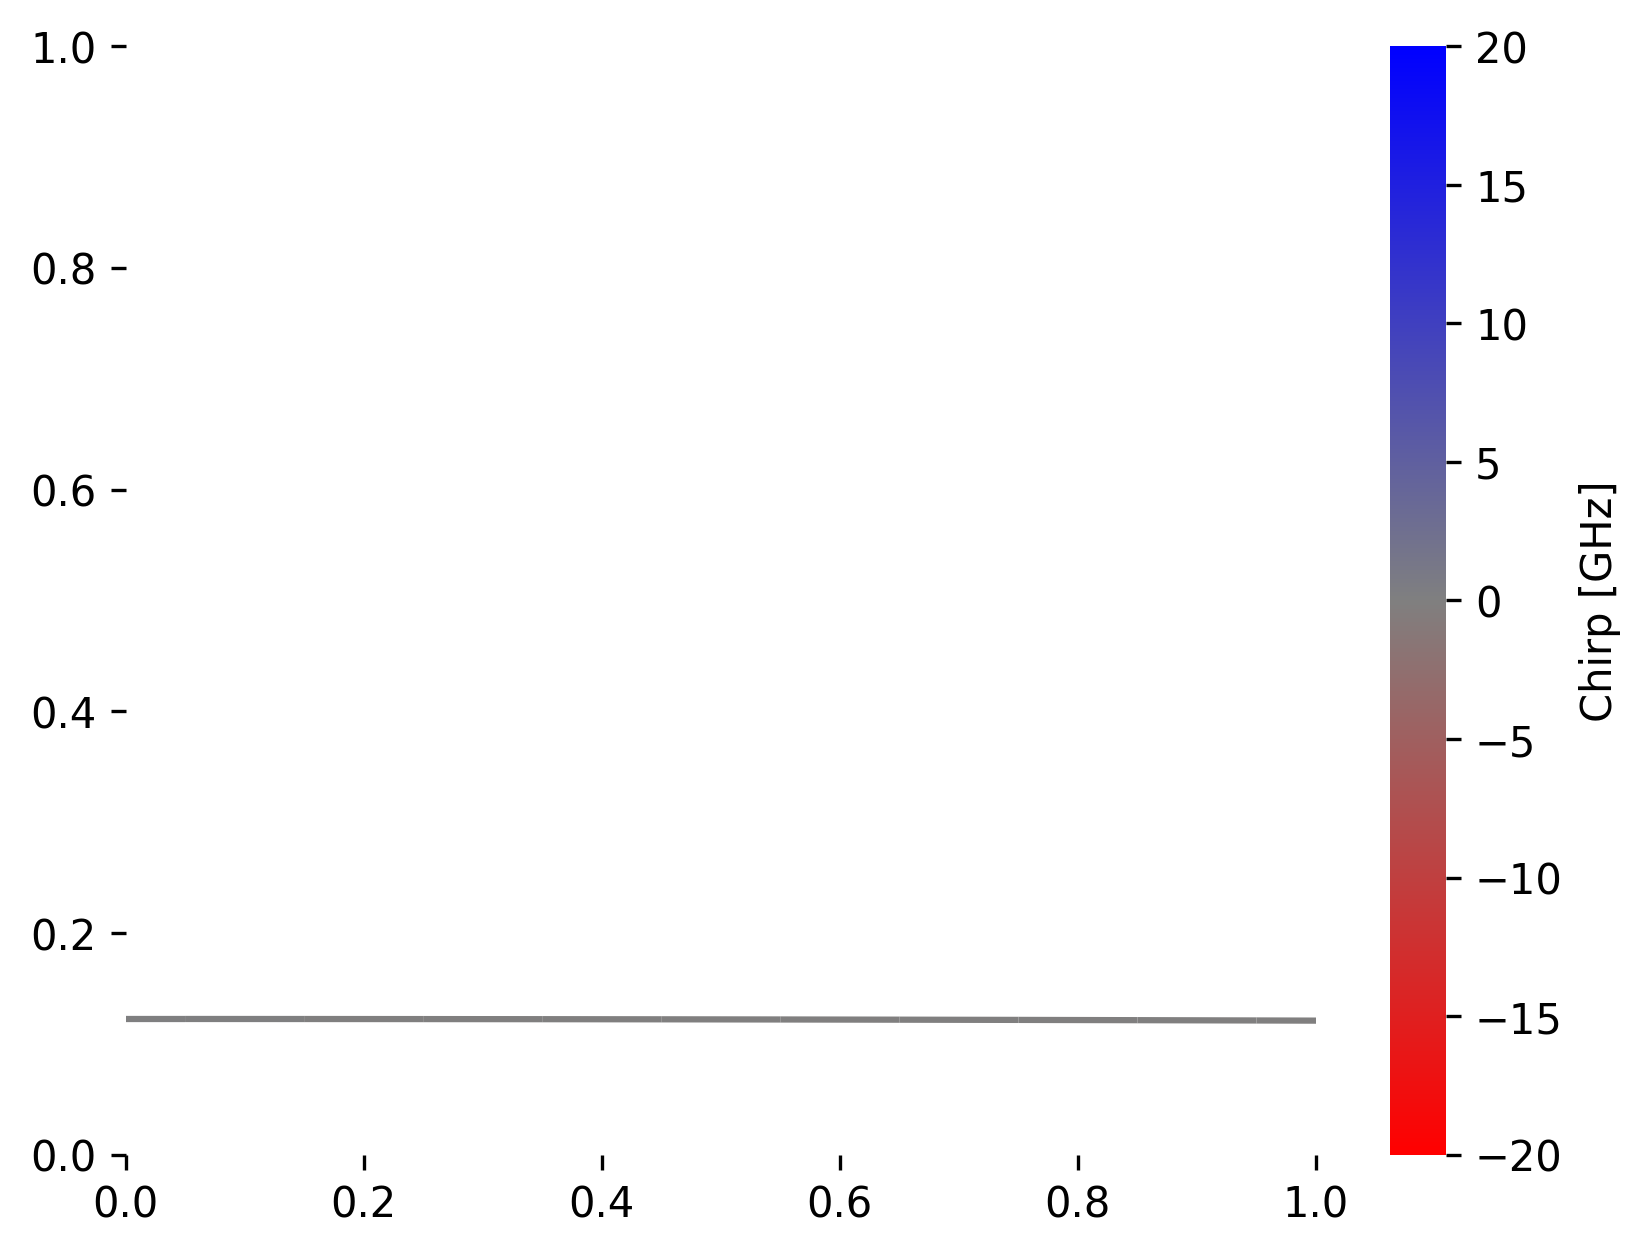

In [50]:
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.legend import LineCollection
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

points = np.array( [sim_config.t*1e12 ,  getPower(pulseMatrix_sech[fiber_test.ntraces-1,:])   ]  ).T.reshape(-1,1,2)
segments = np.concatenate([points[0:-1],points[1:]],axis=1)

#Make custom colormap
colors = ["red" ,"gray", "blue"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

#Initialize color normalization function
norm = plt.Normalize(-20,20)

#Initialize line collection to be plotted
lc=LineCollection(segments,cmap=cmap1,norm=norm)
lc.set_array( getChirp(sim_config.t,pulseMatrix_sech[fiber_test.ntraces-1,:])/1e9 )

#Initialize figure
fig, ax = plt.subplots(dpi=300)
line = ax.add_collection(lc)
fig.colorbar(line,ax=ax, label = 'Chirp [GHz]')


#Function for specifying axes
def init():
  # ax.set_title(f'Soliton evolution, N={N}')

  ax.set_xlim([-duration_test*2.5*1e12,duration_test*2.5*1e12])
  ax.set_ylim([0,1.05*np.max( np.abs(pulseMatrix_sech) )**2])
  
  ax.set_xlabel('Time [ps]')
  ax.set_ylabel('Power [W]')
#Function for updating the plot in the .gif
def update(i):
  ax.clear() #Clear figure
  init()     #Reset axes
  ax.set_title(f'Soliton, N={N}, Distance = {int(i / nsteps_test * Length_test)} m')

  #Make collection of points from pulse power
  points = np.array( [sim_config.t*1e12 ,  getPower(pulseMatrix_sech[i,:])   ]  ).T.reshape(-1,1,2)
  
  #Make collection of lines from points
  segments = np.concatenate([points[0:-1],points[1:]],axis=1)
  lc=LineCollection(segments,cmap=cmap1,norm=norm)

  #Activate norm function based on local chirp
  lc.set_array( getChirp(sim_config.t,pulseMatrix_sech[i,:])/1e9 )
  
  #Plot line
  line = ax.add_collection(lc)



#Make animation
ani = FuncAnimation(fig,update,range(fiber_test.ntraces),init_func=init)
plt.show()

#Save animation as .gif
framerate=30 # Framerate of 30 will look smooth
writer = PillowWriter(fps=framerate)
ani.save(f'SolitonChirpGif_N={N}_fps={framerate}_dpi=300.gif',writer=writer)


## Things to investigate!



1.   How does the runtime change when you alter N (number of time divisions)?
2.   Can you implement [3rd order dispersion](https://www.rp-photonics.com/third_order_dispersion.html) as well?
3.   How does the maximum chirp from dispersion change as a function of |$\beta_2$|?
4.   How does the maximum chirp from SPM change as a function of $\gamma$?
5.   Can you find a negative value of $\beta_2$ that cancels out the chirp created by $\gamma$? 




